# load data

In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage
import numpy as np

In [2]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
from collections import defaultdict


df = pd.read_csv("/data/0_curation/rtog_final_curation_ctv.csv")
crop_3d = [0,160,6,294,2,322] # 160, 288, 320
crop_2d = [6,294,2,322] # 288, 320

paths = {
    "image": "/data/7_image_interpolated_resized/rtog_{}_image_interpolated_resized_raw_xx.nrrd",
    "lung": "/data/10_lung_interpolated_resized/rtog_{}_lung_interpolated_resized_raw_xx.nrrd",
    "heart": "/data/9_heart_interpolated_resized/rtog_{}_heart_interpolated_resized_raw_xx.nrrd",
    "cord": "/data/11_cord_interpolated_resized/rtog_{}_cord_interpolated_resized_raw_xx.nrrd",
    "esophagus": "/data/8_esophagus_interpolated_resized/rtog_{}_esophagus_interpolated_resized_raw_xx.nrrd",
    "ctv": "/data/12_ctv_interpolated_resized/rtog_{}_ctv_interpolated_resized_raw_xx.nrrd"
}

def print_shape(obj, mode):
    print ("{} image shape :: {} \n{} label shape :: {}".format(
        mode, obj["images"].shape,
        mode, obj["labels"].shape))

def get_arr(patient_id, label):
    """
    Reads a nrrd file and spits out a numpy array.
    """
    path_to_nrrd = paths[label].format(patient_id)
    label = sitk.ReadImage(path_to_nrrd)
    return sitk.GetArrayFromImage(label)

def format_2d_array(arr, crop_2d, mode="label"):
    """
    Crops, reshapes, and creates a RGB image (or binary label) of a 2D array.
    crop_2d [start_y, end_y, start_x, end_x]
    """
    arr = arr[crop_2d[0]:crop_2d[1], crop_2d[2]:crop_2d[3]]
    if mode == "image":
        arr = arr.reshape(*arr.shape, 1)
        arr = np.interp(arr,[-1024,3071],[0,1])
        arr = np.repeat(arr, 3, axis=2)
    return arr

def format_3d_array(arr, crop_3d, mode="label"):
    """
    Crops, reshapes, and creates a RGB image (or binary label) of a 3D array.
    crop_3d [start_z, end_z, start_y, end_y, start_x, end_x]
    """
    arr = arr[crop_3d[0]:crop_3d[1], crop_3d[2]:crop_3d[3], crop_3d[4]:crop_3d[5]]
    arr = arr.reshape(*arr.shape, 1)
    if mode == "image":
        arr = np.interp(arr,[-1024,3071],[0,1])
        arr = np.repeat(arr, 3, axis=3)
    return arr

def generate_train_tune_data(start, end):
    """
    For 2d slice-by-slice models. (ignores patients)
    """
    images = []
    labels = []
    label_order = ["ctv", "heart", "lung", "esophagus", "cord"]
    # read dataframe
    for idx,pat in enumerate(df["patid"].tolist()[start:end]):
        # read image and get array
        path_to_nrrd = paths["image"].format(pat)
        image = sitk.ReadImage(path_to_nrrd)
        arr_image = sitk.GetArrayFromImage(image)
        # read label and get array
        label_arrays = {
            "lung": get_arr(pat, "lung"),
            "heart": get_arr(pat, "heart"),
            "cord": get_arr(pat, "cord"),
            "esophagus": get_arr(pat, "esophagus"),
            "ctv": get_arr(pat, "ctv")
        }
        counter = 0
        # filter out all blank slices
        for i in range(arr_image.shape[0]):
            # get that slice
            slice_image = arr_image[i]
            if np.unique(slice_image).size != 1:
                counter += 1
                slice_image = format_2d_array(slice_image, crop_2d, mode="image")
                images.append(slice_image)
                combined_label = []
                # get 5 labels and append them
                for label in label_order:
                    slice_label = format_2d_array(label_arrays[label][i], crop_2d)
                    combined_label.append(slice_label)
                combined_label = np.stack(combined_label, axis=2)
                labels.append(combined_label)
        print ("{}_{}_{}/160".format(idx, pat, counter))

    return {
            "images": np.array(images),
            "labels": np.array(labels)
           }

# def generate_test_data(start, end):
#     """
#     For 2d slice-by-slice models (will bundle slices per patient).
#     Unlike generate_train_tune_data, this will return all labels.
#     """
#     test_data = []
#     # read dataframe
#     for idx,pat in enumerate(df["patid"].tolist()[start:end]):
#         image_sitk_obj = sitk.ReadImage(paths["image"].format(pat))
#         image_arr = sitk.GetArrayFromImage(image_sitk_obj)
#         test_data.append(
#          {"patid": pat,
#           "image_sitk_obj" : image_sitk_obj,
#           "image_arr": image_arr,
#           "image": format_3d_array(image_arr, crop_3d, mode="image"),
#           "labels" : {
#                 "lung": format_3d_array(get_arr(pat, "lung"), crop_3d),
#                 "heart": format_3d_array(get_arr(pat, "heart"), crop_3d),
#                 "cord": format_3d_array(get_arr(pat, "cord"), crop_3d),
#                 "esophagus": format_3d_array(get_arr(pat, "esophagus"), crop_3d),
#                 "ctv": format_3d_array(get_arr(pat, "ctv"), crop_3d)
#                 }
#           }
#         )
#         print ("{}_{}".format(idx, pat))
#     return test_data

def get_data(mode="train"):
    """
    For mode == "train":
        data["train"]["images"][i]
        data["train"]["labels"][i]
    For mode == "test":
        data[i]["patid"]
        data[i]["image_sitk_obj"] # sitk object
        data[i]["image_arr"]..[j] for slice # raw numpy array
        data[i]["image"]..[j] for slice # formatted ready for model
        data[i]["labels"]["lung"]..[j] for slice
    """
    if mode=="train":
        data = {
            "train": generate_train_tune_data(0, 330), # 330
            "tune": generate_train_tune_data(330, 360) # 360
        }
        print_shape(data["train"], "train")
        print_shape(data["tune"], "tune")
    elif mode=="test":
        data = generate_test_data(360, 426) #426
        print ("test cases :: {}\ntest image shape :: {}\ntest label shape :: {}".format(len(data), data[0]["image"].shape, data[0]["labels"]["lung"].shape))
    return data


In [3]:
data = get_data()


0_0617-259694_93/160
1_0617-305105_127/160
2_0617-308175_160/160
0_0617-715810_128/160
1_0617-716741_120/160
train image shape :: (380, 288, 320, 3) 
train label shape :: (380, 288, 320, 5)
tune image shape :: (248, 288, 320, 3) 
tune label shape :: (248, 288, 320, 5)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

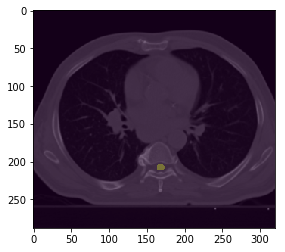

In [13]:
i=140
plt.imshow(data["train"]["images"][i])
plt.imshow(data["train"]["labels"][i,:,:,4], alpha=0.3)
plt.show()

In [413]:
images = np.load("/output/single_model_images.npy")
labels = np.load("/output/single_model_labels.npy")
images.shape, labels.shape

((536, 288, 320, 3), (536, 288, 320, 5))

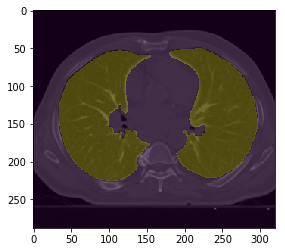

In [435]:
i = 140
plt.imshow(images[i])
plt.imshow(labels[i][:,:,0], alpha=0.3)
plt.show()

In [433]:
labels[80].shape

(288, 320, 5)

In [436]:
labels[80][:,:,0].shape

(288, 320)

In [409]:
arrs_combined = np.stack(arrs, axis=2)
arrs_combined.shape

(288, 320, 2)

In [411]:
arrs_combined[:,:,1]

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

In [375]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
from collections import defaultdict


df = pd.read_csv("/data/0_curation/rtog_final_curation_ctv.csv")
crop_3d = [0,160,6,294,2,322] # 160, 288, 320
crop_2d = [6,294,2,322] # 288, 320

paths = {
    "image": "/data/7_image_interpolated_resized/rtog_{}_image_interpolated_resized_raw_xx.nrrd",
    "lung": "/data/10_lung_interpolated_resized/rtog_{}_lung_interpolated_resized_raw_xx.nrrd",
    "heart": "/data/9_heart_interpolated_resized/rtog_{}_heart_interpolated_resized_raw_xx.nrrd",
    "cord": "/data/11_cord_interpolated_resized/rtog_{}_cord_interpolated_resized_raw_xx.nrrd",
    "esophagus": "/data/8_esophagus_interpolated_resized/rtog_{}_esophagus_interpolated_resized_raw_xx.nrrd",
    "ctv": "/data/12_ctv_interpolated_resized/rtog_{}_ctv_interpolated_resized_raw_xx.nrrd"
}

def print_shape(obj, mode):
    print ("{} image shape :: {} \n{} {} label shape :: {}\n{} {} label shape :: {}\n{} {} label shape :: {}\n{} {} label shape :: {}\n{} {} label shape :: {}".format(
        mode, obj["images"].shape,
        mode, "lung", obj["labels"]["lung"].shape,
        mode, "heart", obj["labels"]["heart"].shape,
        mode, "cord", obj["labels"]["cord"].shape,
        mode, "esophagus", obj["labels"]["esophagus"].shape,
        mode, "ctv", obj["labels"]["ctv"].shape)
        )

def get_arr(patient_id, label):
    """
    Reads a nrrd file and spits out a numpy array.
    """
    path_to_nrrd = paths[label].format(patient_id)
    label = sitk.ReadImage(path_to_nrrd)
    return sitk.GetArrayFromImage(label)

def format_2d_array(arr, crop_2d, mode="label"):
    """
    Crops, reshapes, and creates a RGB image (or binary label) of a 2D array.
    crop_2d [start_y, end_y, start_x, end_x]
    """
    arr = arr[crop_2d[0]:crop_2d[1], crop_2d[2]:crop_2d[3]]
    arr = arr.reshape(*arr.shape, 1)
    if mode == "image":
        arr = np.interp(arr,[-1024,3071],[0,1])
        arr = np.repeat(arr, 3, axis=2)
    return arr


def format_3d_array(arr, crop_3d, mode="label"):
    """
    Crops, reshapes, and creates a RGB image (or binary label) of a 3D array.
    crop_3d [start_z, end_z, start_y, end_y, start_x, end_x]
    """
    arr = arr[crop_3d[0]:crop_3d[1], crop_3d[2]:crop_3d[3], crop_3d[4]:crop_3d[5]]
    arr = arr.reshape(*arr.shape, 1)
    if mode == "image":
        arr = np.interp(arr,[-1024,3071],[0,1])
        arr = np.repeat(arr, 3, axis=3)
    return arr

def generate_train_tune_data(labels, start, end):
    """
    For 2d slice-by-slice models. (ignores patients)
    """
    images = []
    label_lists = defaultdict(list)
    # read dataframe
    for idx,pat in enumerate(df["patid"].tolist()[start:end]):
        # read image and get array
        path_to_nrrd = paths["image"].format(pat)
        image = sitk.ReadImage(path_to_nrrd)
        arr_image = sitk.GetArrayFromImage(image)
        # read label and get array
        label_arrays = {
            "lung": get_arr(pat, "lung"),
            "heart": get_arr(pat, "heart"),
            "cord": get_arr(pat, "cord"),
            "esophagus": get_arr(pat, "esophagus"),
            "ctv": get_arr(pat, "ctv")
        }
        counter = 0
        # filter out all blank slices
        for i in range(arr_image.shape[0]):
            # get that slice
            slice_image = arr_image[i]
            if np.unique(slice_image).size != 1:
                counter += 1
                slice_image = format_2d_array(slice_image, crop_2d, mode="image")
                images.append(slice_image)
                # get label and append
                for l in labels:
                    slice_label = format_2d_array(label_arrays[l][i], crop_2d)
                    label_lists[l].append(slice_label)

        print ("{}_{}_{}/160".format(idx, pat, counter))

    return {"images": np.array(images),
            "labels": {
                "lung": np.array(label_lists["lung"]),
                "heart": np.array(label_lists["heart"]),
                "cord": np.array(label_lists["cord"]),
                "esophagus": np.array(label_lists["esophagus"]),
                "ctv": np.array(label_lists["ctv"])
            }
           }

def generate_test_data(start, end):
    """
    For 2d slice-by-slice models (will bundle slices per patient).
    Unlike generate_train_tune_data, this will return all labels.
    """
    test_data = []
    # read dataframe
    for idx,pat in enumerate(df["patid"].tolist()[start:end]):
        image_sitk_obj = sitk.ReadImage(paths["image"].format(pat))
        image_arr = sitk.GetArrayFromImage(image_sitk_obj)
        test_data.append(
         {"patid": pat,
          "image_sitk_obj" : image_sitk_obj,
          "image_arr": image_arr,
          "image": format_3d_array(image_arr, crop_3d, mode="image"),
          "labels" : {
                "lung": format_3d_array(get_arr(pat, "lung"), crop_3d),
                "heart": format_3d_array(get_arr(pat, "heart"), crop_3d),
                "cord": format_3d_array(get_arr(pat, "cord"), crop_3d),
                "esophagus": format_3d_array(get_arr(pat, "esophagus"), crop_3d),
                "ctv": format_3d_array(get_arr(pat, "ctv"), crop_3d)
                }
          }
        )
        print ("{}_{}".format(idx, pat))
    return test_data


def get_data(labels=[], mode="train"):
    """
    For mode == "train":
        data["train"]["images"][i]
        data["train"]["labels"]["lung"][i]
    For mode == "test":
        data[i]["patid"]
        data[i]["image_sitk_obj"] # sitk object
        data[i]["image_arr"]..[j] for slice # raw numpy array
        data[i]["image"]..[j] for slice # formatted ready for model
        data[i]["labels"]["lung"]..[j] for slice
    """
    if mode=="train":
        data = {
            "train": generate_train_tune_data(labels, 0, 2), # 330
            "tune": generate_train_tune_data(labels, 330, 331) # 360
        }
        print_shape(data["train"], "train")
        print_shape(data["tune"], "tune")
    elif mode=="test":
        data = generate_test_data(360, 426) #426
        print ("test cases :: {}\ntest image shape :: {}\ntest label shape :: {}".format(len(data), data[0]["image"].shape, data[0]["labels"]["lung"].shape))
    return data


FileNotFoundError: File b'/data/0_curation/rtog_final_curation_ctv.csv' does not exist

In [308]:
data = get_data(labels=["lung", "heart", "cord", "esophagus", "ctv"])
# data = get_data(mode="test")

0_0617-747279
1_0617-748036
test cases :: 2
test image shape :: (160, 288, 320, 3)
test label shape :: (160, 288, 320, 1)


In [321]:
def generate_sitk_obj_from_npy_array(image_sitk_obj, image_arr, pred_npy_array, output_dir=""):
    print (type(image_arr), type(pred_npy_array))
    """
    image_sitk_obj: sitk object of input to model
    image_arr: array of sitk object of input to model
    pred_npy_array: returned prediction from model
    NOTE: image_arr.shape will always be equal or larger than pred_npy_array.shape, but never smaller gievn that
    we are always cropping in data.py
    """
    # change pred_npy_array.shape to match image_arr.shape
    # getting amount of padding needed on each side
    z_diff = int((image_arr.shape[0] - pred_npy_array.shape[0]) / 2)
    y_diff = int((image_arr.shape[1] - pred_npy_array.shape[1]) / 2)
    x_diff = int((image_arr.shape[2] - pred_npy_array.shape[2]) / 2)
    # 
    pred_npy_array = np.pad(pred, ((z_diff, z_diff), (y_diff, y_diff), (x_diff, x_diff), (0, 0)), 'constant')
    # remove channel
    pred_npy_array = pred_npy_array.reshape(*image_arr.shape)
    print (image_arr.shape, pred_npy_array.shape)
    # save sitk obj
    new_sitk_object = sitk.GetImageFromArray(pred_npy_array)
    new_sitk_object.SetSpacing(image_sitk_obj.GetSpacing())
    new_sitk_object.SetOrigin(image_sitk_obj.GetOrigin())
    assert new_sitk_object.GetSize() == image_sitk_obj.GetSize(), "oops.. The shape of the returned array does not match your requested shape."
    if output_dir != "":
        writer = sitk.ImageFileWriter()
        writer.SetFileName(output_dir)
        writer.SetUseCompression(True)
        writer.Execute(new_sitk_object)
    else:
        return new_sitk_object
    

In [325]:
image_sitk_obj = data[0]["image_sitk_obj"]
image_arr = data[0]["image_arr"]
pred_npy_array = np.load("/output/2d_multi_model/0617-747279_lung.npy")
output_dir = "/output/2d_multi_model/0617-747279_lung_prediction.nrrd"

si = generate_sitk_obj_from_npy_array(image_sitk_obj, image_arr, pred_npy_array, output_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/output/2d_multi_model/0617-747279_lung.npy'

In [373]:
pred_npy_array = sitk.GetArrayFromImage(sitk.ReadImage("/output/2d_multi_model/0617-747279_lung_prediction.nrrd"))
pred_npy_array = pred_npy_array.reshape(*pred_npy_array.shape,1)
print(len(pred_npy_array[pred_npy_array==0]))
pred_npy_array = ndimage.binary_fill_holes(pred_npy_array)
print(len(pred_npy_array[pred_npy_array==0]))

14191325
14191325


(160, 300, 324)

In [365]:
def threshold(pred, thresh=0.5):
    pred[pred<thresh] = 0
    pred[pred>=thresh] = 1
    return pred.astype(np.int8)

In [366]:
pred_npy_array = threshold(pred_npy_array)
len(pred_npy_array[pred_npy_array==0])

14191325

14188812

In [278]:
sitk.GetArrayFromImage(data[0]['image_sitk_obj']).shape

(160, 300, 324)

In [279]:

pred.shape

(160, 288, 320, 1)

(160, 288, 320, 1) (160, 288, 320, 1)


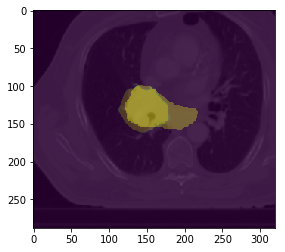

In [268]:
pred = np.load("/output/2d_multi_model/0617-747279_ctv.npy")
gt = data[0]["labels"]["ctv"]
img = data[0]["image"]
print(pred.shape, gt.shape)
i = 80
plt.imshow(img[i])
plt.imshow(pred[i].reshape(288,320), alpha=0.3)
plt.imshow(gt[i].reshape(288,320), alpha=0.3)
plt.show()

In [242]:
# https://gist.github.com/brunodoamaral/e130b4e97aa4ebc468225b7ce39b3137
def dice_coefficient_test(gt, pred, thresh=True):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    gt : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    pred : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0

    """
    if thresh:
        pred = threshold(pred)
    gt = np.asarray(gt).astype(np.bool)
    pred = np.asarray(pred).astype(np.bool)

    if gt.shape != pred.shape:
        raise ValueError("Shape mismatch: gt and pred must have the same shape.")

    im_sum = gt.sum() + pred.sum()
    if im_sum == 0:
        raise ValueError("Both arrays are empty.")

    # Compute Dice coefficient
    intersection = np.logical_and(gt, pred)

    return 2. * intersection.sum() / im_sum


In [247]:
dice_coefficient_test(gt, pred, thresh=False)

0.963423441243206

In [250]:
def dice_coefficient_np(y_true, y_pred, smooth=1.):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [251]:
dice_coefficient_np(gt, pred)

0.9634234542554823

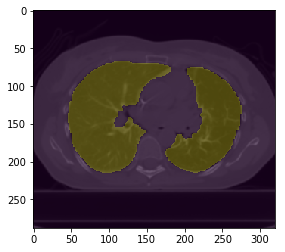

In [218]:
data[1]["labels"]["lung"][34].shape

(288, 320, 1)

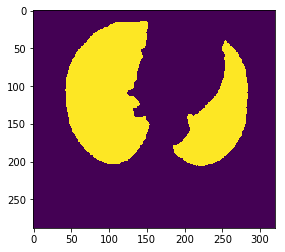

In [174]:
plt.imshow(data["train"]["labels"]["lung"][300].reshape(288,320))

In [179]:
data["train"]["labels"]["lung"][300].max()

1

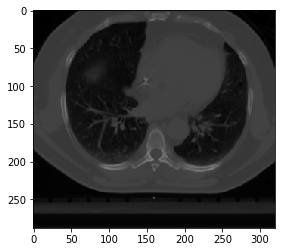

In [176]:
plt.imshow(data["train"]["images"][300])

0_0617-747279
1_0617-748036
test cases :: 2
test image shape :: (160, 288, 320, 3)
test label shape :: (160, 288, 320, 1)


In [158]:
data["images"]

KeyError: 'images'

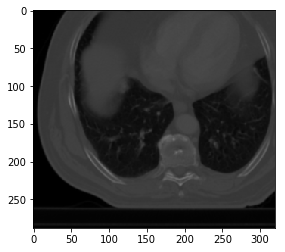

In [154]:
plt.imshow(data[0]["image"][60])

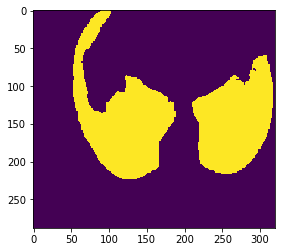

In [155]:
plt.imshow(data[0]["labels"]["lung"][60].reshape(288,320))

In [228]:
def dice_coefficient(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [229]:
def dice_coefficient_np(y_true, y_pred, smooth=1.):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [ ]:
dice_coefficient_np

In [231]:
pred = np.load("/output/predictions/test.npy")
pred.shape, pred.min(), pred.max()

((95, 288, 320, 1), 0.0, 1.0)

In [223]:
pred

array([[[[5.8412552e-06],
         [1.1920929e-07],
         [3.2782555e-07],
         ...,
         [2.9802322e-07],
         [1.4901161e-07],
         [5.3942204e-06]],

        [[1.1920929e-07],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00]],

        [[2.0861626e-07],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [2.0861626e-07]],

        ...,

        [[2.0861626e-07],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [2.6822090e-07]],

        [[8.9406967e-08],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [1.4901161e-07]],

        [[6.4074993e-06],
         [1.1920929e-07],
         [5.0663948e-07],
         ...,
         [4.7683716e-07],
        

In [222]:
pred.astype(np.bool)

array([[[[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[ True],
         [False],
         [False],
         ...,
         [False],
         [False],
         [ True]],

        ...,

        [[ True],
         [False],
         [False],
         ...,
         [False],
         [False],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [False],
         [False],
         [ True]],

        [[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]]],


       [[[ True],
         [ True],
         [ True],
         ...,
         [ True],
         [ True],
         [ True]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [Fa

In [108]:
dice(data["test"]["labels"]["cord"], pred)

0.030151514578026412

In [109]:
dice(data["test"]["labels"]["cord"], threshold(pred))

0.8937183860722268

In [110]:
def threshold(pred, thresh=0.5):
    pred[pred<thresh] = 0
    pred[pred>=thresh] = 1
    return pred.astype(np.int8)

def measures(true, pred):
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_measures_filter.Execute(sitk.GetImageFromArray(true), sitk.GetImageFromArray(pred))
    return overlap_measures_filter.GetDiceCoefficient()

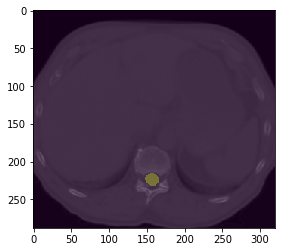

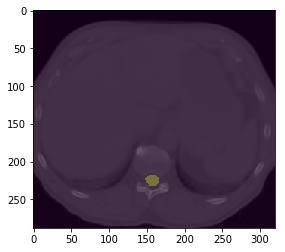

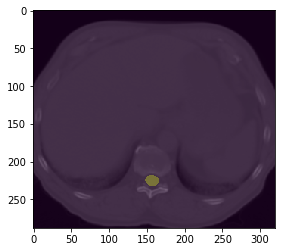

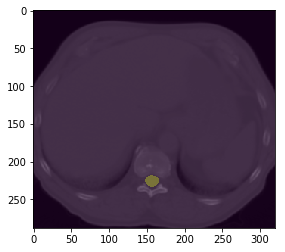

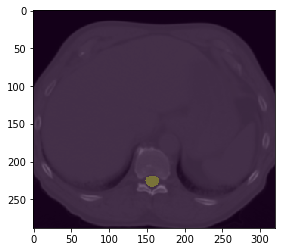

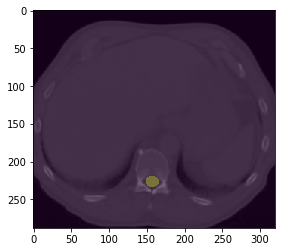

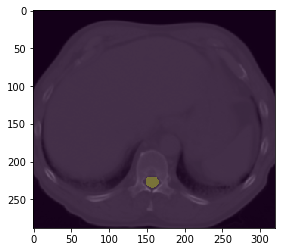

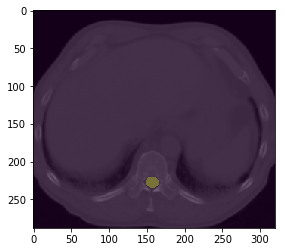

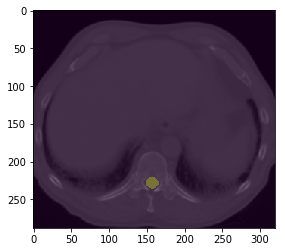

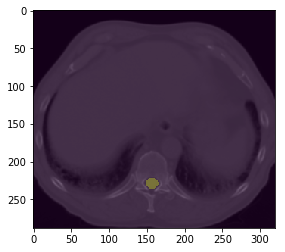

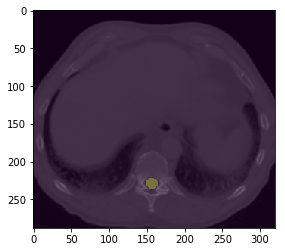

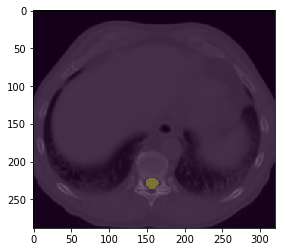

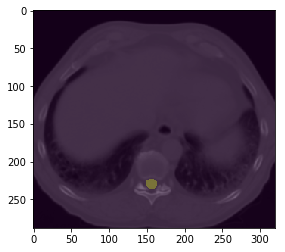

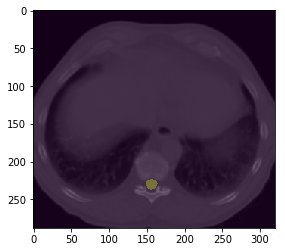

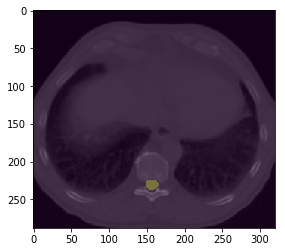

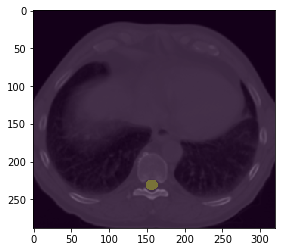

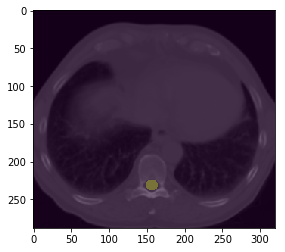

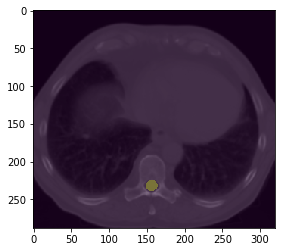

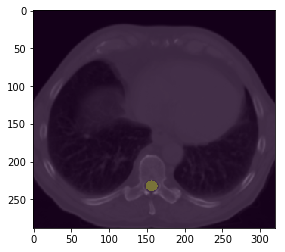

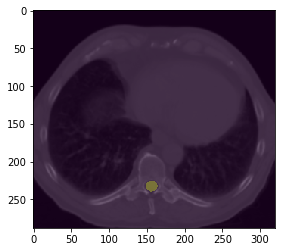

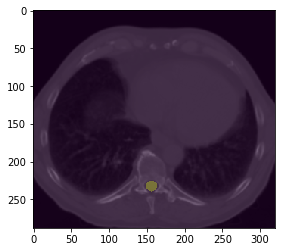

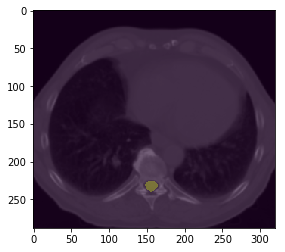

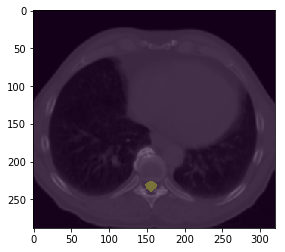

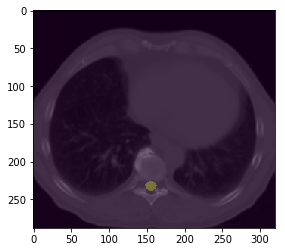

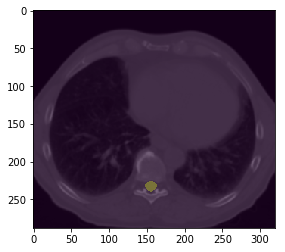

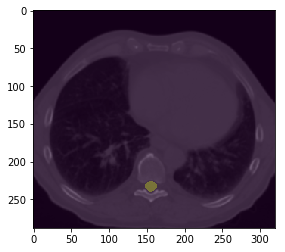

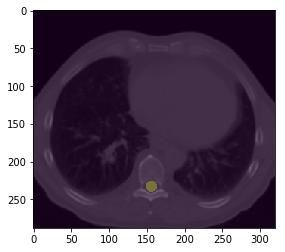

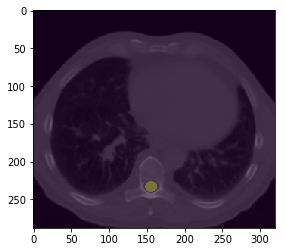

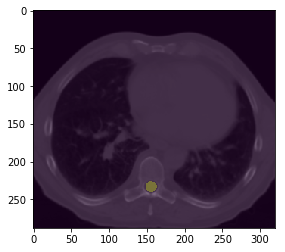

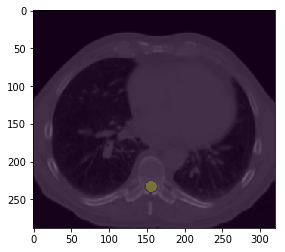

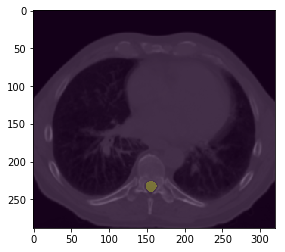

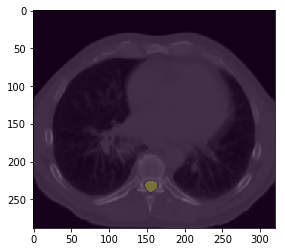

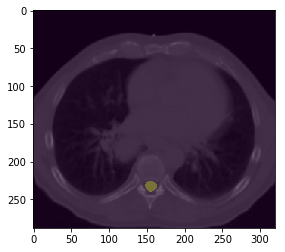

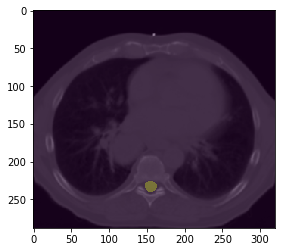

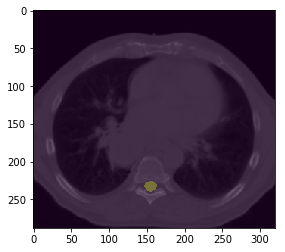

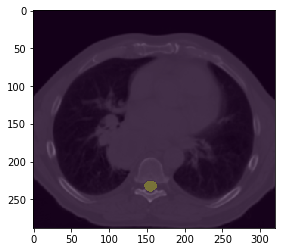

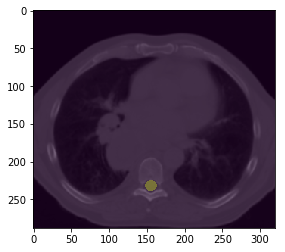

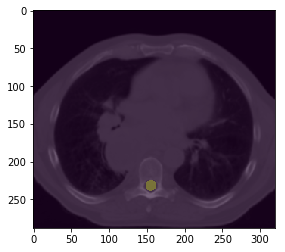

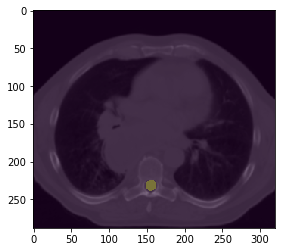

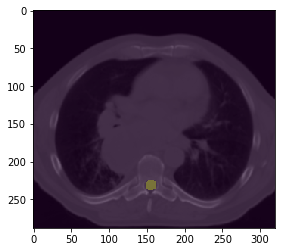

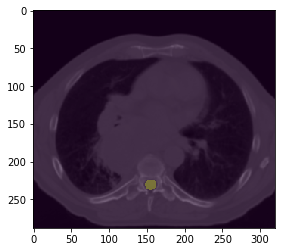

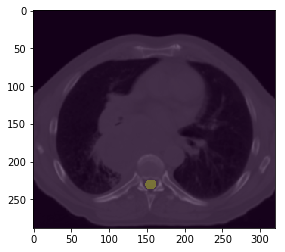

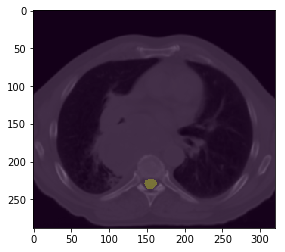

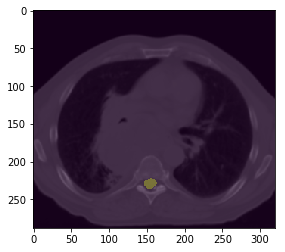

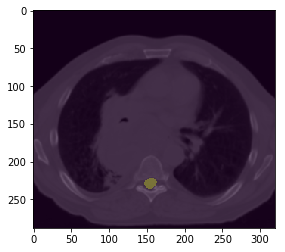

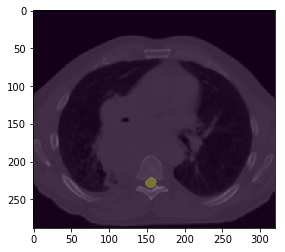

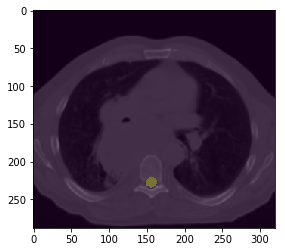

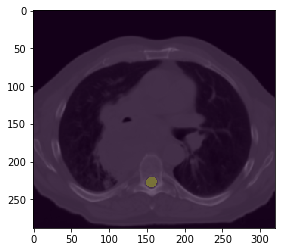

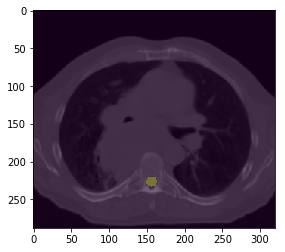

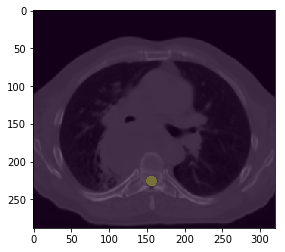

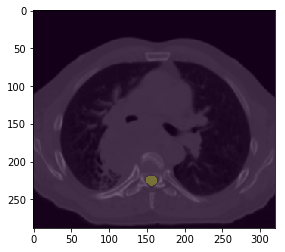

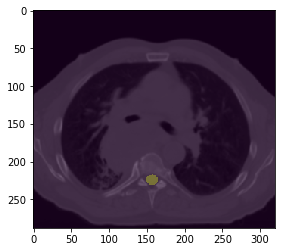

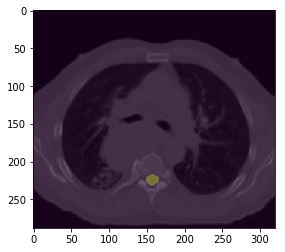

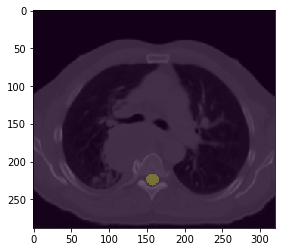

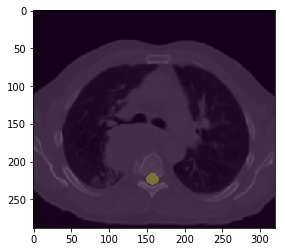

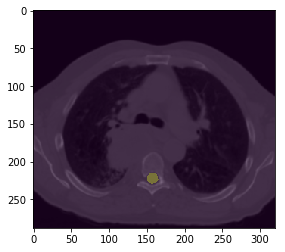

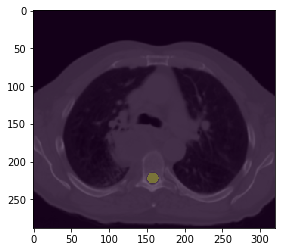

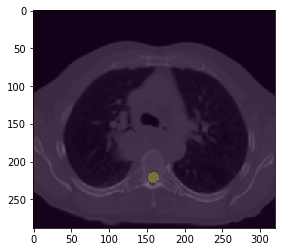

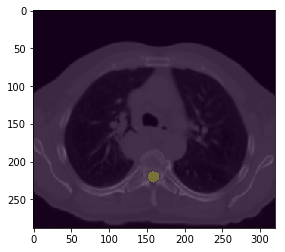

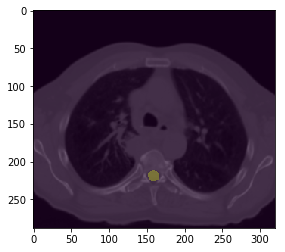

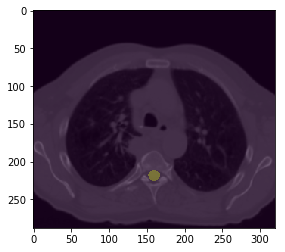

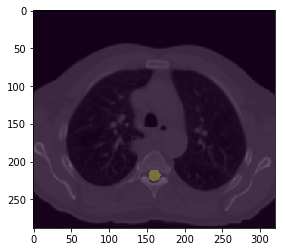

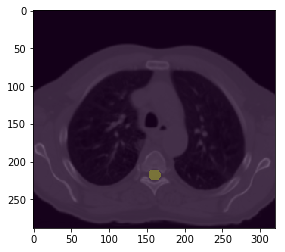

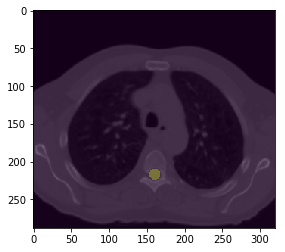

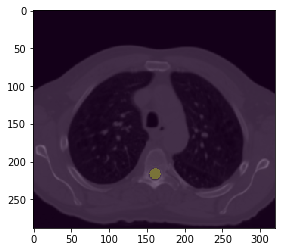

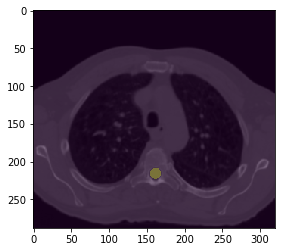

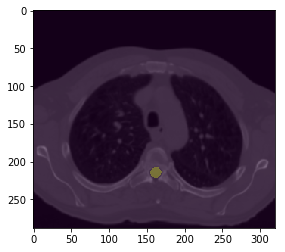

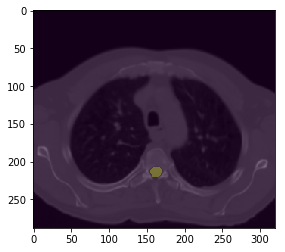

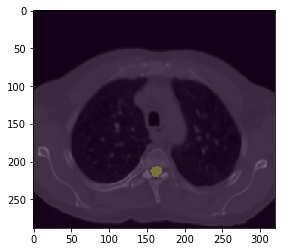

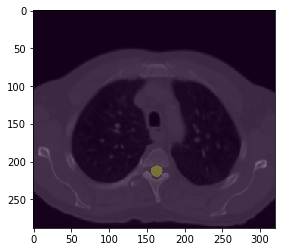

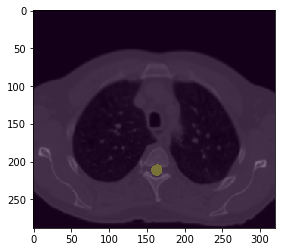

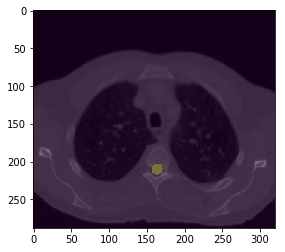

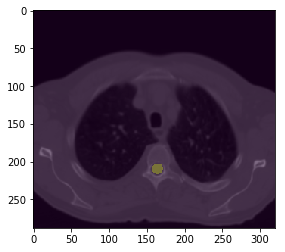

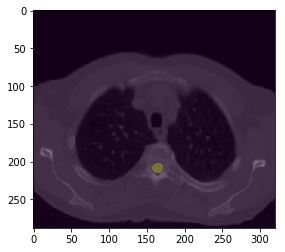

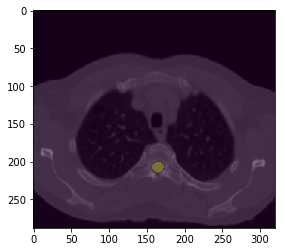

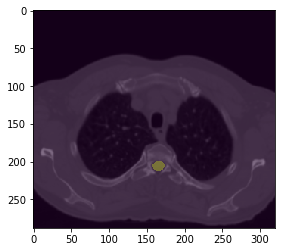

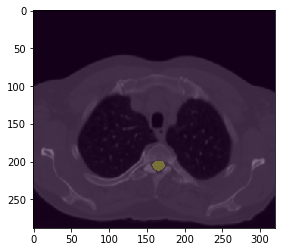

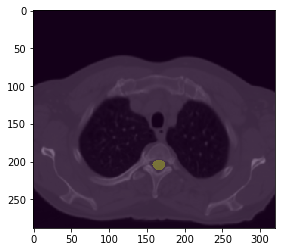

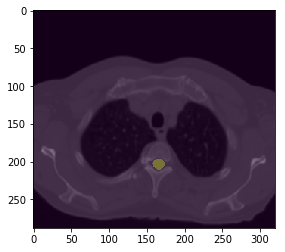

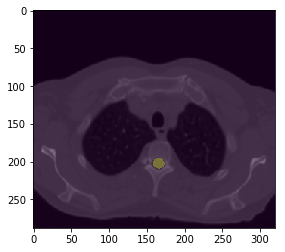

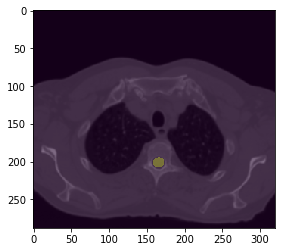

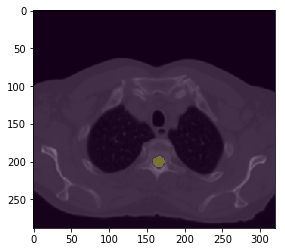

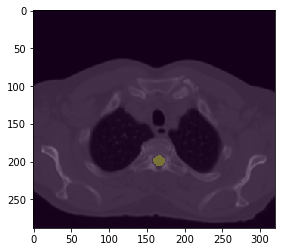

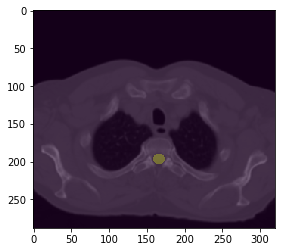

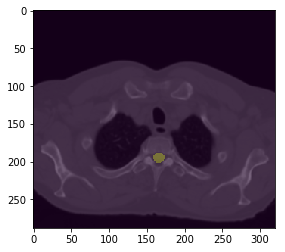

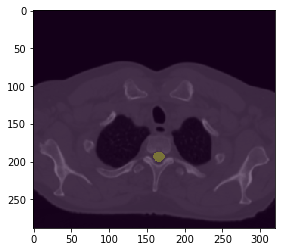

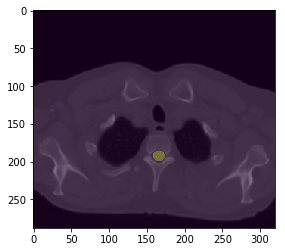

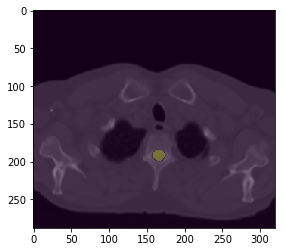

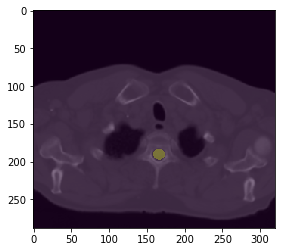

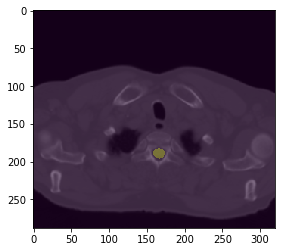

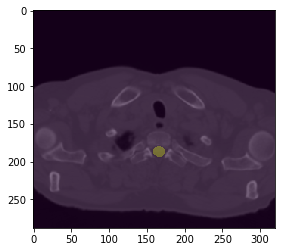

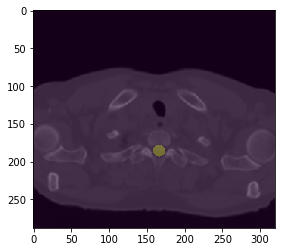

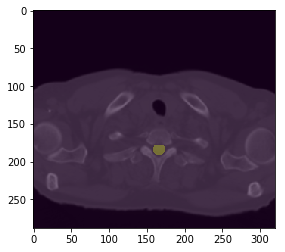

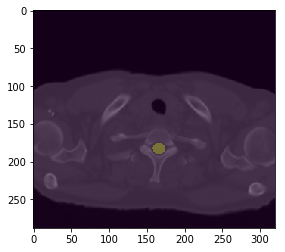

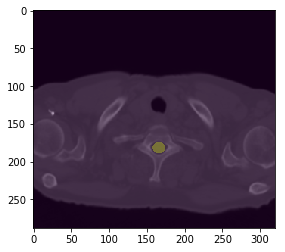

In [111]:
# image = plt.imread("/output/images/image_53_2719.png")
# label = plt.imread("/output/labels/label_53_2719.png")
dices = []
for i in range(95):
    plt.imshow(data["test"]["images"][i])
    plt.imshow(pred[i].reshape(288,320), alpha=0.3)
#     plt.imshow(data["test"]["labels"]["heart"][i].reshape(288,320), alpha=0.3)
#     dices.append(measures(data["test"]["labels"]["heart"][i], threshold(pred[i])))
#     print(measures(data["test"]["labels"]["heart"][i], threshold(pred[i])))
    plt.show()

In [4]:
image = sitk.ReadImage("/mnt/aertslab/DATA/Lung/RTOG_0617/0_processed/14_image_interpolated_resized_rescaled/rtog_0617-309598_image_interpolated_resized_rescaled_xx.nrrd")
arr_image = sitk.GetArrayFromImage(image)
arr_image.shape

(80, 100, 108)

In [60]:
np.mean([ x for x in dices if x != np.inf])

0.9384143744926313

In [71]:
measures(data["test"]["labels"]["lung"].astype(np.float32), threshold(pred).astype(np.float32))

RuntimeError: Exception thrown in SimpleITK LabelOverlapMeasuresImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkMemberFunctionFactory.hxx:196:
sitk::ERROR: Pixel type: vector of 32-bit float is not supported in 3D byN3itk6simple31LabelOverlapMeasuresImageFilterE

In [43]:
from keras import backend as K
def dice_coefficient(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [73]:
# https://gist.github.com/brunodoamaral/e130b4e97aa4ebc468225b7ce39b3137
def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0

    Notes
    -----
    The order of inputs for dice is irrelevant. The result will be
    identical if im1 and im2 are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        raise ValueError("Both arrays are empty.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

0.9731104332826005

In [75]:
pred



array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [154]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
from collections import defaultdict

df = pd.read_csv("/data/0_curation/rtog_final_curation_ctv.csv")

label_paths = {
    "image": "/data/7_image_interpolated_resized/rtog_{}_image_interpolated_resized_raw_xx.nrrd",
    "lung": "/data/10_lung_interpolated_resized/rtog_{}_lung_interpolated_resized_raw_xx.nrrd",
    "heart": "/data/9_heart_interpolated_resized/rtog_{}_heart_interpolated_resized_raw_xx.nrrd",
    "cord": "/data/11_cord_interpolated_resized/rtog_{}_cord_interpolated_resized_raw_xx.nrrd",
    "esophagus": "/data/8_esophagus_interpolated_resized/rtog_{}_esophagus_interpolated_resized_raw_xx.nrrd",
    "ctv": "/data/12_ctv_interpolated_resized/rtog_{}_ctv_interpolated_resized_raw_xx.nrrd"
}
    
def print_shape(obj, mode):
    print ("{} image shape :: {} \n{} {} label shape :: {}\n{} {} label shape :: {}\n{} {} label shape :: {}\n{} {} label shape :: {}\n{} {} label shape :: {}".format(
        mode, obj["images"].shape, 
        mode, "lung", obj["labels"]["lung"].shape,
        mode, "heart", obj["labels"]["heart"].shape,
        mode, "cord", obj["labels"]["cord"].shape,
        mode, "esophagus", obj["labels"]["esophagus"].shape,
        mode, "ctv", obj["labels"]["ctv"].shape)
          )

def get_arr(patient_id, label):    
    path_to_nrrd = label_paths[label].format(patient_id)
    label = sitk.ReadImage(path_to_nrrd)
    return sitk.GetArrayFromImage(label)
    
def add_slice(label_lists, arr, index, label):
    slice_label = arr[index]
    slice_label = slice_label[6:294,2:322]
    slice_label = slice_label.reshape(288, 320, 1)
    label_lists[label].append(slice_label)

def generate_data(labels, start, end):
    images = []
    label_lists = defaultdict(list)
    # read dataframe
    for idx,pat in enumerate(df["patid"].tolist()[start:end]):
        # read image and get array
        path_to_nrrd = label_paths["image"].format(pat)
        image = sitk.ReadImage(path_to_nrrd)
        arr_image = sitk.GetArrayFromImage(image)
        # read label and get array
        label_arrays = {
            "lung": get_arr(pat, "lung"),
            "heart": get_arr(pat, "heart"),
            "cord": get_arr(pat, "cord"),
            "esophagus": get_arr(pat, "esophagus"),
            "ctv": get_arr(pat, "ctv")
        }  
        counter = 0
        # filter out all blank slices
        for i in range(arr_image.shape[0]):
            # get that slice
            slice_image = arr_image[i]
            if np.unique(slice_image).size != 1:
                counter += 1
                # remap to 0 to 1
                slice_image =  np.interp(slice_image,[-1024,3071],[0,1])
                # slim down slightly so dimensions work with network
                slice_image = slice_image[6:294,2:322]
                # connvert to RGB and append
                slice_image = np.repeat(slice_image.reshape(288, 320, 1), 3, axis=2)
                images.append(slice_image)
                # get label and append
                for l in labels:
                    add_slice(label_lists, label_arrays[l], i, l)

        print ("{}_{}_{}/160".format(idx, pat, counter))

    return {"images": np.array(images), 
            "labels": {
                "lung": np.array(label_lists["lung"]),
                "heart": np.array(label_lists["heart"]),
                "cord": np.array(label_lists["cord"]),
                "esophagus": np.array(label_lists["esophagus"]),
                "ctv": np.array(label_lists["ctv"])
            }
           }


def get_data(labels):
    data = {
        "train": generate_data(labels, 0, 10),
        "tune": generate_data(labels, 300, 301),
        # "test": generate_data(350,426)
    }
    print_shape(data["train"], "train")
    print_shape(data["tune"], "tune")
    # print_shape(data["test"], "test")
    return data

In [155]:
labels = ["lung", "heart", "cord", "esophagus", "ctv"]
data = get_data(labels)

0_0617-259694_93/160
1_0617-305105_127/160
2_0617-308175_160/160
3_0617-313260_156/160
4_0617-342808_132/160
5_0617-349454_132/160
6_0617-355467_141/160
7_0617-359104_127/160
8_0617-368409_143/160
9_0617-380962_160/160
0_0617-697905_160/160
train image shape :: (1371, 288, 320, 3) 
train lung label shape :: (1371, 288, 320, 1)
train heart label shape :: (1371, 288, 320, 1)
train cord label shape :: (1371, 288, 320, 1)
train esophagus label shape :: (1371, 288, 320, 1)
train ctv label shape :: (1371, 288, 320, 1)
tune image shape :: (160, 288, 320, 3) 
tune lung label shape :: (160, 288, 320, 1)
tune heart label shape :: (160, 288, 320, 1)
tune cord label shape :: (160, 288, 320, 1)
tune esophagus label shape :: (160, 288, 320, 1)
tune ctv label shape :: (160, 288, 320, 1)


In [156]:
len(data["train"]["images"])

1371

In [ ]:
2742

In [159]:
42907 / 32
# 4117

1340.84375

In [158]:
1371*2

2742

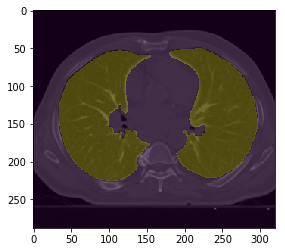

In [145]:
plt.imshow(data["train"]["images"][140])
plt.imshow(data["train"]["labels"]["lung"][140].reshape(288,320), alpha=0.3)
plt.show()

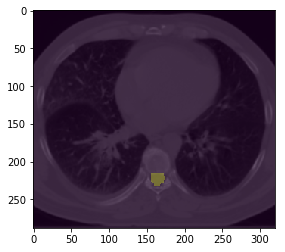

In [149]:
plt.imshow(data["tune"]["images"][80])
plt.imshow(data["tune"]["labels"]["cord"][80].reshape(288,320), alpha=0.3)
plt.show()

In [131]:
160+124+97

381

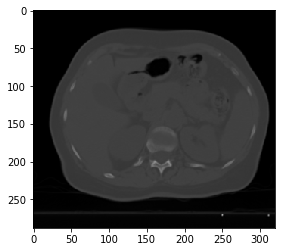

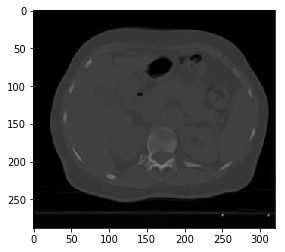

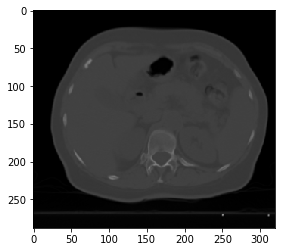

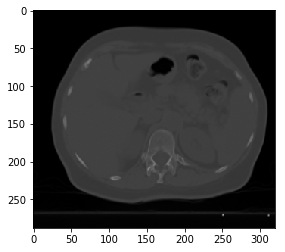

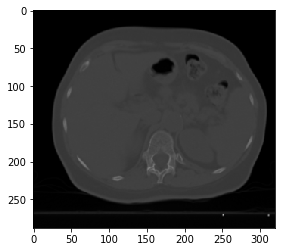

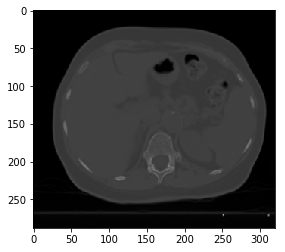

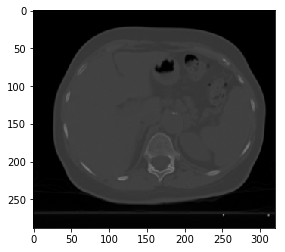

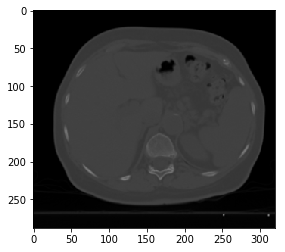

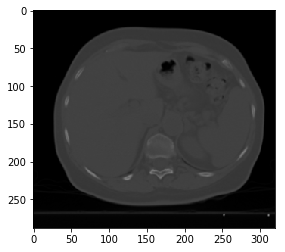

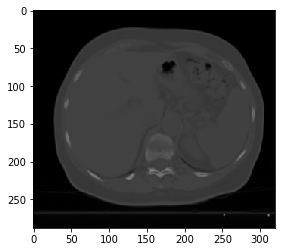

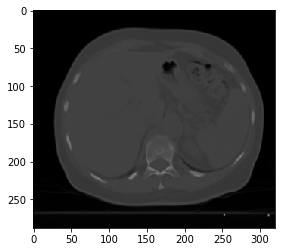

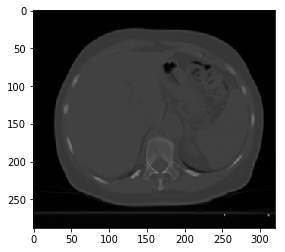

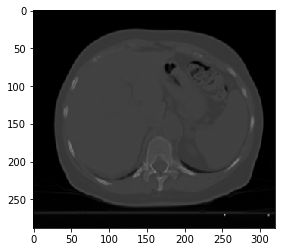

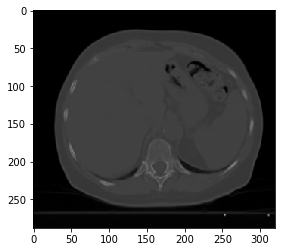

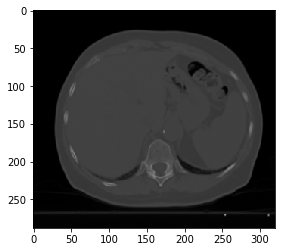

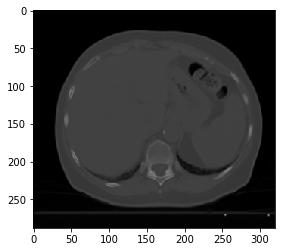

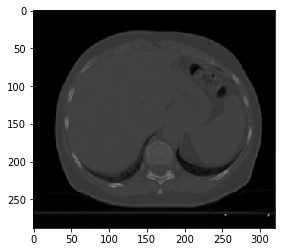

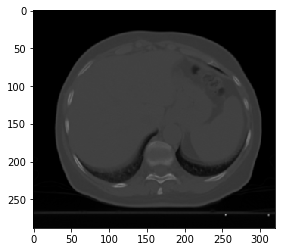

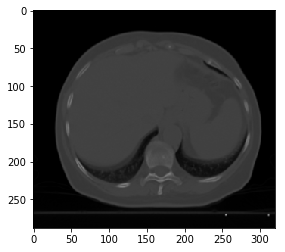

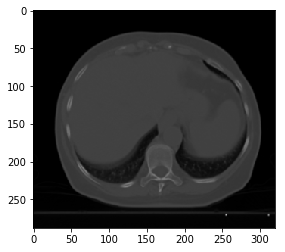

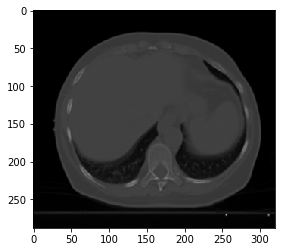

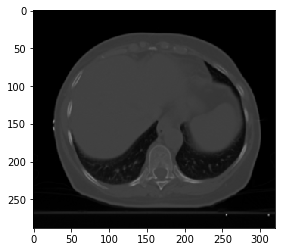

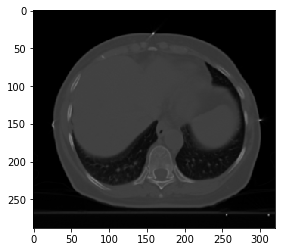

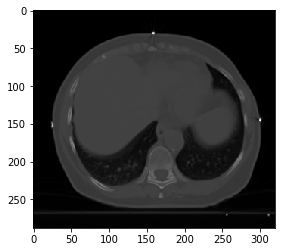

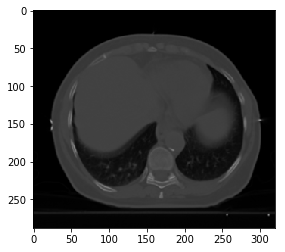

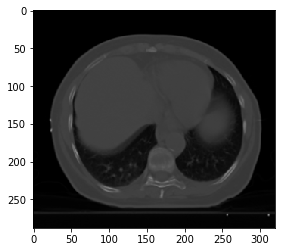

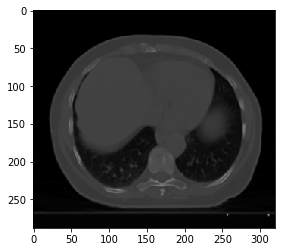

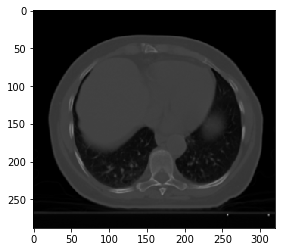

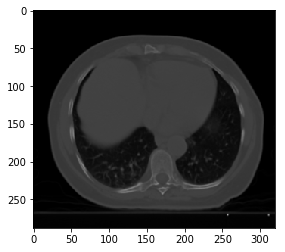

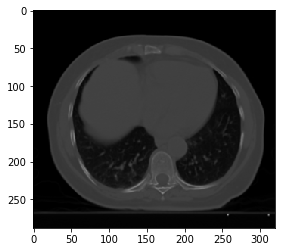

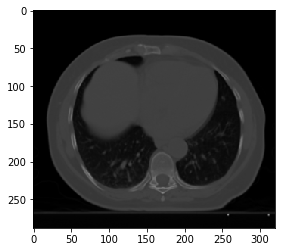

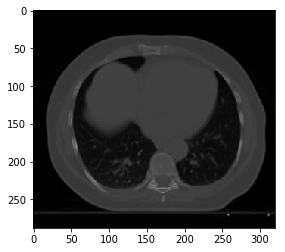

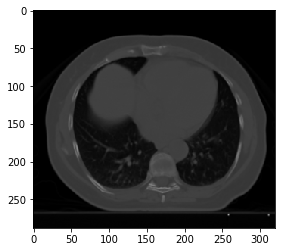

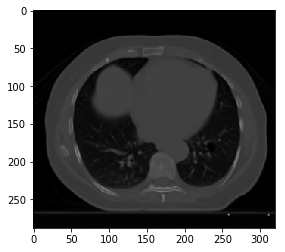

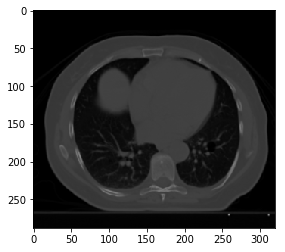

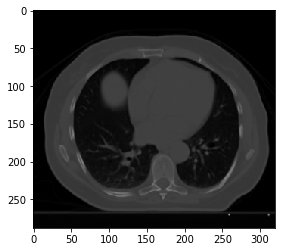

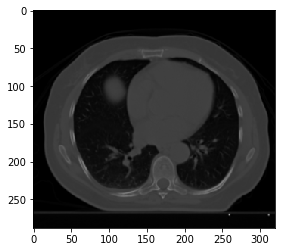

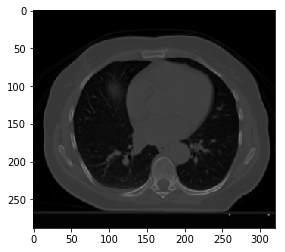

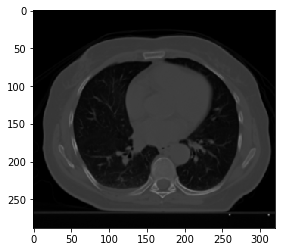

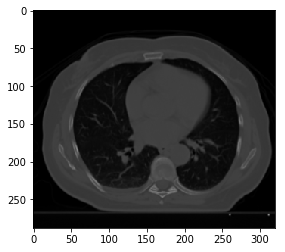

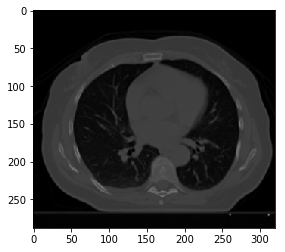

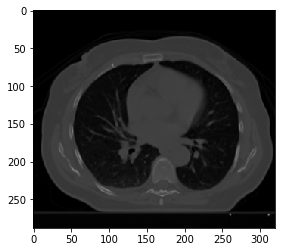

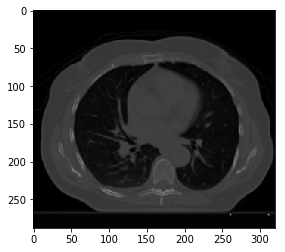

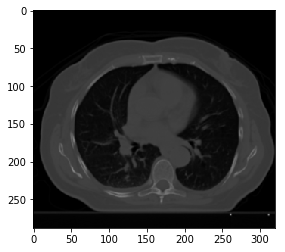

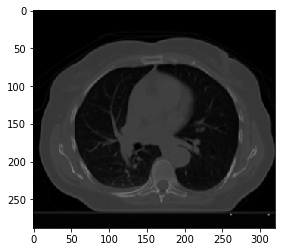

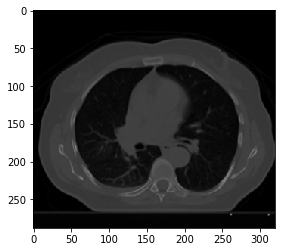

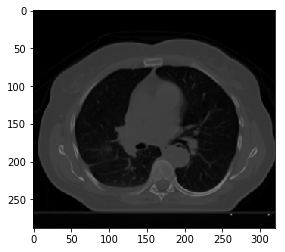

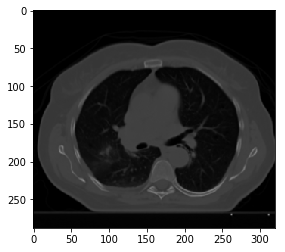

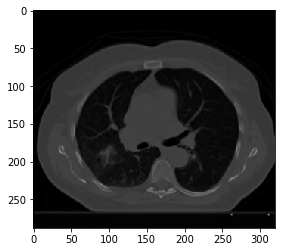

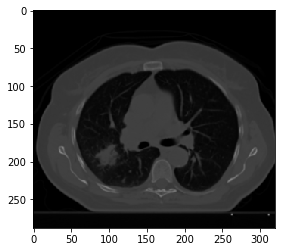

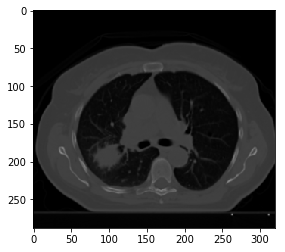

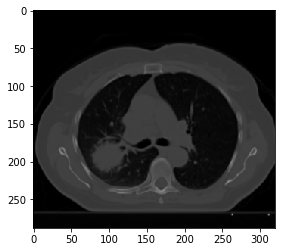

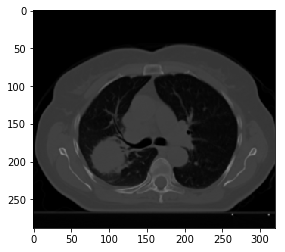

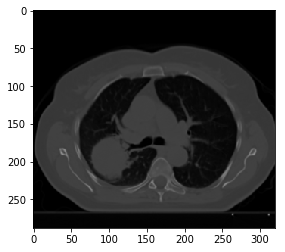

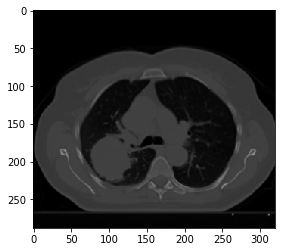

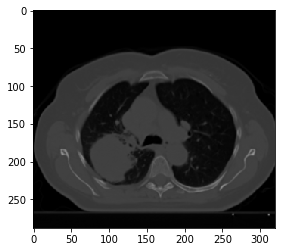

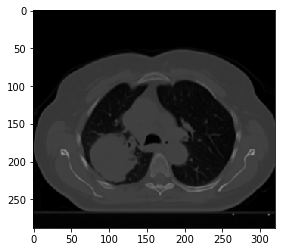

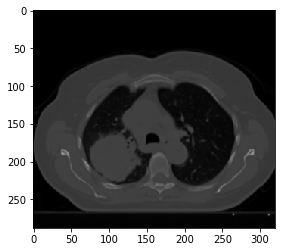

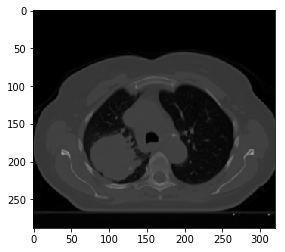

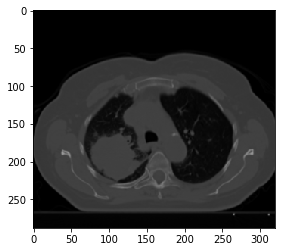

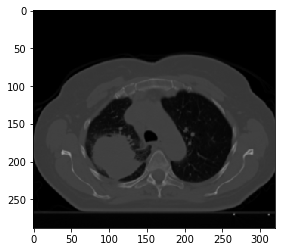

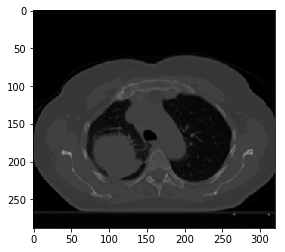

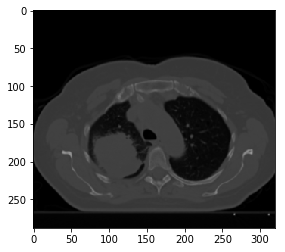

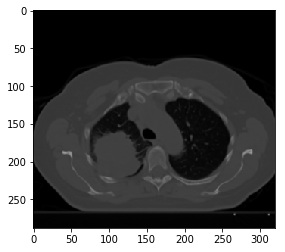

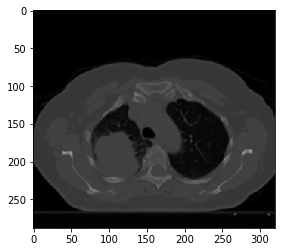

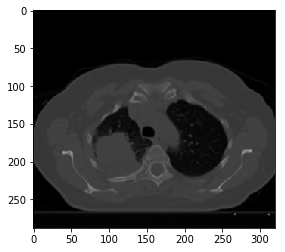

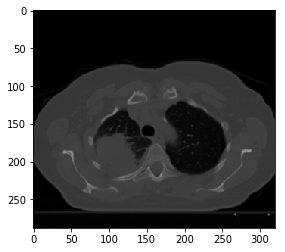

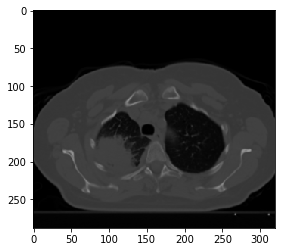

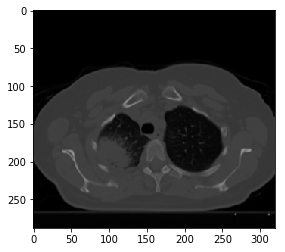

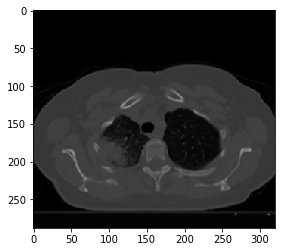

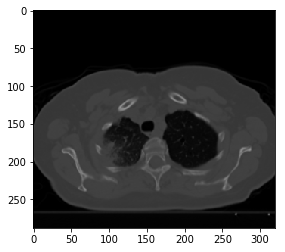

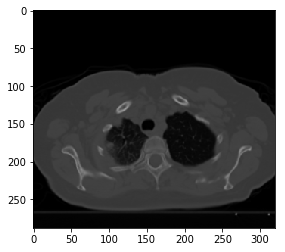

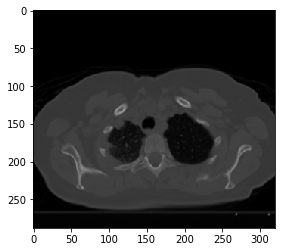

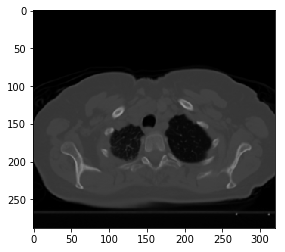

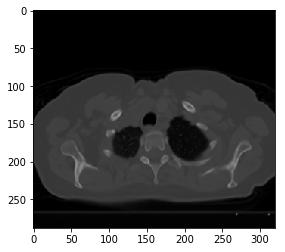

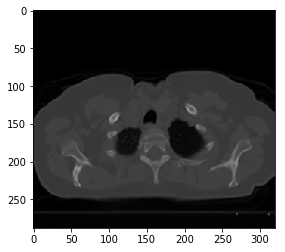

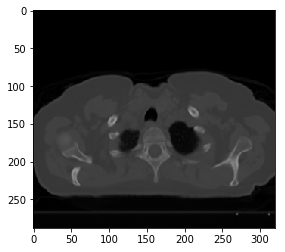

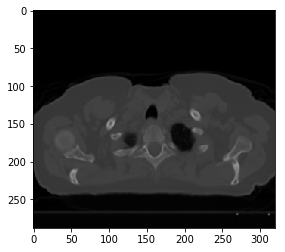

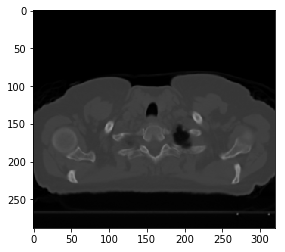

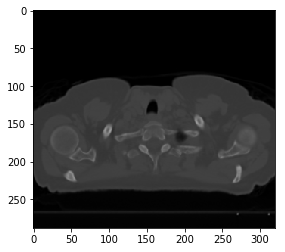

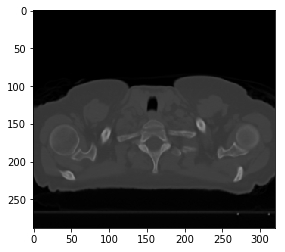

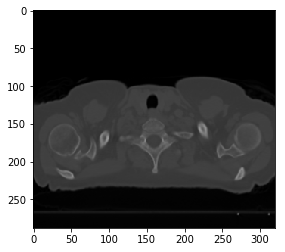

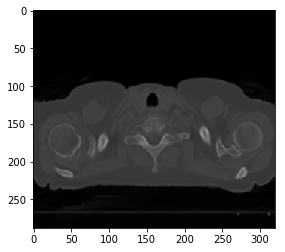

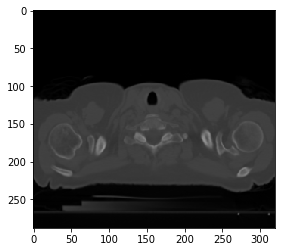

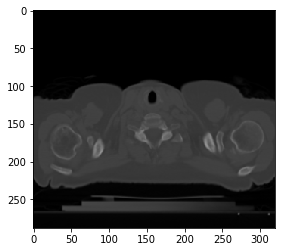

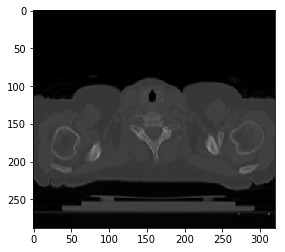

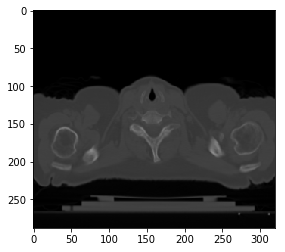

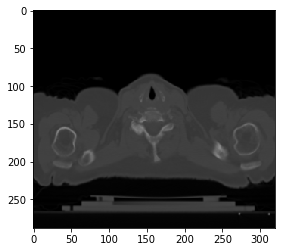

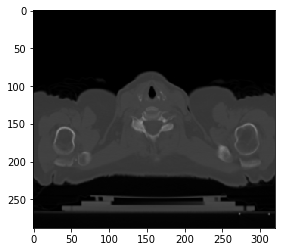

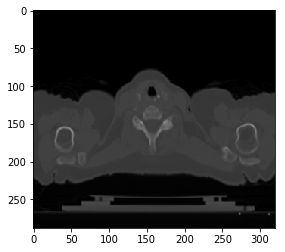

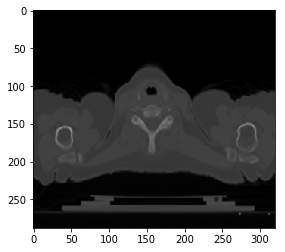

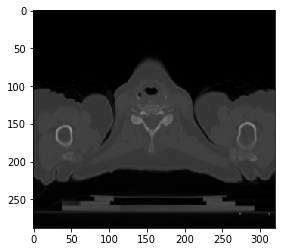

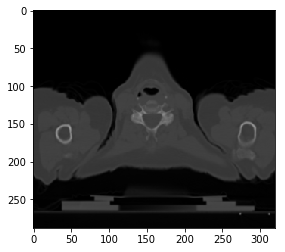

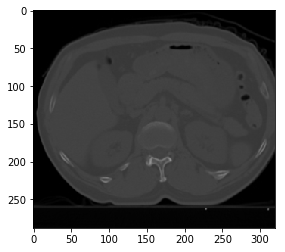

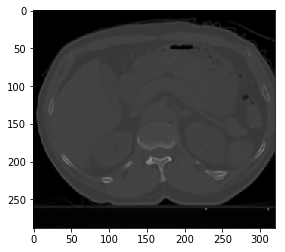

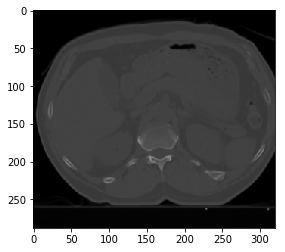

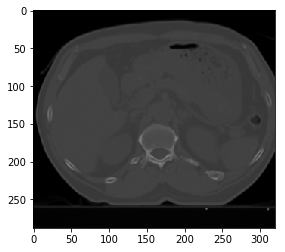

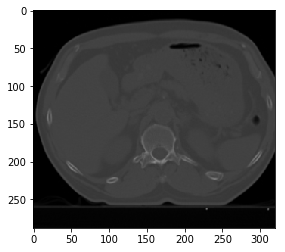

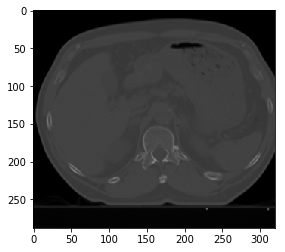

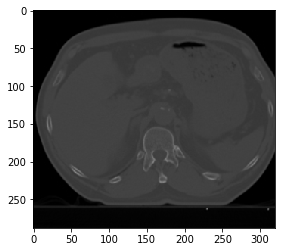

In [78]:
for i in range(0,100):
    plt.imshow(data["train"]["images"][i])
    plt.show()

In [127]:
160*3

480